In [12]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
from models import Autoencoder
from sklearn.decomposition import NMF
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils import translate_text
from sklearn.model_selection import KFold
import shap
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna
from sklearn.model_selection import KFold
import torch.nn.functional as F
import io
from PIL import Image
from utils import get_cbcl_details
import random
from torch.utils.data import DataLoader, TensorDataset


In [2]:
seed = 6  # 你可以设成其他任何整数
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # 多卡也能同步
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
code_dir = Path(os.getcwd())
data_path = code_dir.parent / "data"
assert os.path.exists(
    data_path
), "Data directory not found. Make sure you're running this code from the root directory of the project."

with open(data_path / "cbcl_data_remove_unrelated.csv", "r", encoding="utf-8") as f:
    qns = pd.read_csv(f)

X = qns.iloc[:, 1:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.2)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

items = [get_cbcl_details(col) for col in qns.iloc[:, 1:].columns]
items = np.array(items)

## pure decorrelation Autoencoder

In [5]:
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same


# the autoencoder architecture
class AutoencoderModel(nn.Module):
    def __init__(
        self, input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons
    ):
        super(AutoencoderModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, latent_dim),

        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, input_dim),
        )

    def forward(self, x):
        # forward
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def decorrelation_loss(latent_repr):
    """
    计算潜在表示的去相关正则化损失。
    latent_repr: (batch_size, latent_dim)
    """
    batch_size, latent_dim = latent_repr.shape
    # 计算协方差矩阵
    latent_repr = latent_repr - latent_repr.mean(dim=0, keepdim=True)  # 先中心化
    cov_matrix = (latent_repr.T @ latent_repr) / batch_size  # 计算协方差
    mask = torch.eye(latent_dim, device=latent_repr.device)  # 生成单位矩阵
    loss = torch.sum((cov_matrix * (1 - mask))**2)  # 只计算非对角元素
    return loss

class Autoencoder:
    def __init__(
        self,
        X_train,
        X_val,
        encoding_dim,
        layer1_neurons=0,
        layer2_neurons=0,
        layer3_neurons=0,
    ):

        train_dataset = QuestionnaireDataset(X_train)
        val_dataset = QuestionnaireDataset(X_val)

        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=32)

        # Model initialization
        input_dim = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = AutoencoderModel(
            input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons
        ).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.1, patience=5
        )
        self.explained_variance_ratio_total_value = None
    
    def get_model(self):
        return self.model
    
    def train(self, show_plot=False):
        best_val_loss = float("inf")
        patience = 20
        epochs_without_improvement = 0
        train_losses, val_losses = [], []

        # Modify the training loop to include decorrelation loss
        for epoch in range(2000):
            self.model.train()
            train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(batch_features)
                reconstruction_loss = self.criterion(outputs, batch_features)
                
                # Calculate decorrelation loss
                latent_repr = self.model.encoder(batch_features)
                decorrelation_loss_value = decorrelation_loss(latent_repr)
                
                # Combine losses
                combined_loss = reconstruction_loss + decorrelation_loss_value
                
                combined_loss.backward()
                self.optimizer.step()
                train_loss += combined_loss.item() * batch_features.size(0)
            train_losses.append(train_loss / len(self.train_loader.dataset))

            # Validation step
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    outputs = self.model(batch_features)
                    reconstruction_loss = self.criterion(outputs, batch_features)
                    
                    # Calculate decorrelation loss
                    latent_repr = self.model.encoder(batch_features)
                    decorrelation_loss_value = decorrelation_loss(latent_repr)
                    
                    # Combine losses
                    combined_loss = reconstruction_loss + decorrelation_loss_value
                    
                    val_loss += combined_loss.item() * batch_features.size(0)
            val_losses.append(val_loss / len(self.val_loader.dataset))
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        if show_plot:
            # Plot loss curves
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Loss Curves")
            plt.show()

    def evaluate_on_data(self, X):
        self.model.eval()
        with torch.no_grad():
            # Forward pass to get reconstructed data
            if not isinstance(X, np.ndarray):
                X = np.array(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

            reconstructed = self.model(X_tensor)

            # Get the output of the encoder, i.e., latent factors
            latent_factors = self.model.encoder(
                X_tensor
            ).cpu().numpy()

            # Calculate the variance of each latent factor
            latent_variances = np.var(latent_factors, axis=0)

            # Calculate the total variance of the original data
            total_variance = np.var(X, axis=0).sum()

            # Calculate the explained variance ratio for each latent factor
            explained_variance_ratios = latent_variances / total_variance

            # Print the explained variance ratio for each latent factor
            # for i, ratio in enumerate(explained_variance_ratios):
            #     print(f"Explained variance ratio of latent factor {i+1}: {ratio:.8f}")

            # Calculate reconstruction errors
            reconstruction_errors = torch.mean(
                (X_tensor - reconstructed) ** 2,
                dim=1,
            ).cpu().numpy()

            # Calculate the variance contribution of the reconstructed data
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()

            # Calculate the total explained variance ratio
            explained_variance_ratio_total = reconstruction_variance / total_variance
            # print(
            #     f"Total explained variance ratio (by all factors): {explained_variance_ratio_total:.8f}"
            # )

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed
        )


Early stopping at epoch 67


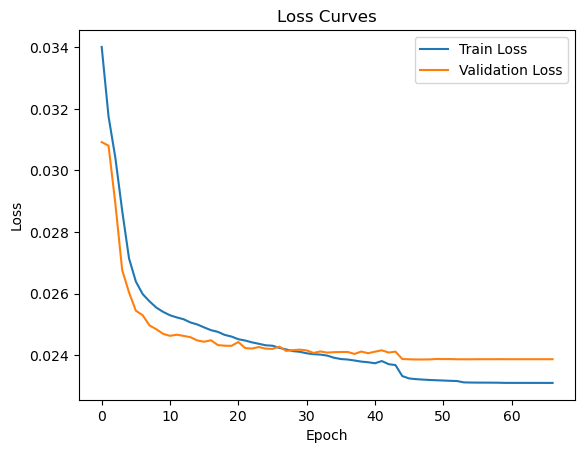

In [6]:
autoencoder = Autoencoder(
    X_train, X_val,
    encoding_dim=5,
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,         # β-VAE 可自由调节
)
autoencoder.train(show_plot=True)

latent_factors, rec_errors, explained_variance_ratios, explained_variance_ratio_total, reconstructed = autoencoder.evaluate_on_data(X_train)
# 这里的 X_train, X_val, X_test 是预先定义好的数据集

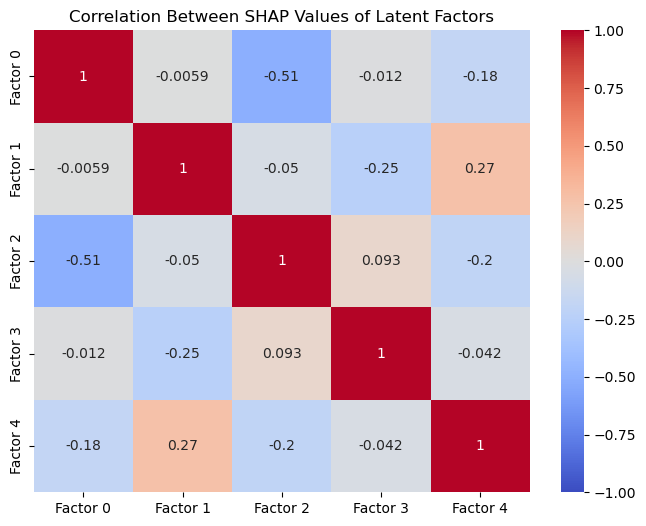

In [ ]:
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wrap the encoder part of the autoencoder as a standalone nn.Module
class EncoderWrapper(nn.Module):
    def __init__(self, model):
        super(EncoderWrapper, self).__init__()
        self.model = model  # The full autoencoder model is passed in

    def forward(self, x):
        output = self.model.encoder(x)  # Only return the encoder's output
        return output.clone()  # Return a cloned copy to avoid in-place issues

# Extract the full model and wrap the encoder
full_model = autoencoder.model
encoder_model = EncoderWrapper(full_model)
encoder_model.to(device)
encoder_model.eval()

# Ensure all ReLU layers are not in-place (required for SHAP compatibility)
for m in full_model.encoder.modules():
    if isinstance(m, torch.nn.ReLU):
        m.inplace = False

# Randomly select 500 samples from training data as SHAP background
# Ensure the background matches the input feature dimension
background = X_train[np.random.choice(X_train.shape[0], 500, replace=False)]

# Construct SHAP DeepExplainer (background must be a tensor on the same device)
explainer = shap.DeepExplainer(
    encoder_model,
    torch.tensor(background, dtype=torch.float32).to(device)
)

# Compute SHAP values for the first 200 samples in the test set
shap_values = explainer.shap_values(
    torch.tensor(X_test[:200], dtype=torch.float32).to(device)
)

# Flatten each latent factor's SHAP values across all samples
latent_dim = shap_values.shape[2]
shap_flat = []

for i in range(latent_dim):
    # Each column corresponds to the flattened SHAP values of one factor
    flattened = shap_values[:, :, i].reshape(-1)
    shap_flat.append(flattened)

# Construct a DataFrame where each column represents one latent factor
shap_df = pd.DataFrame(np.array(shap_flat).T, columns=[f"Factor {i}" for i in range(latent_dim)])

# Compute Pearson correlation matrix between latent factor SHAP values
corr_matrix = shap_df.corr(method='pearson')

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between SHAP Values of Latent Factors")
plt.show()


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_3824\769855620.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,i], X_test[:200], feature_names=items, show=False)
c:\Anaconda\envs\mne\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_3824\769855620.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,i], X_test[:200], feature_names=items, show=False)
c:\Anaconda\envs\m

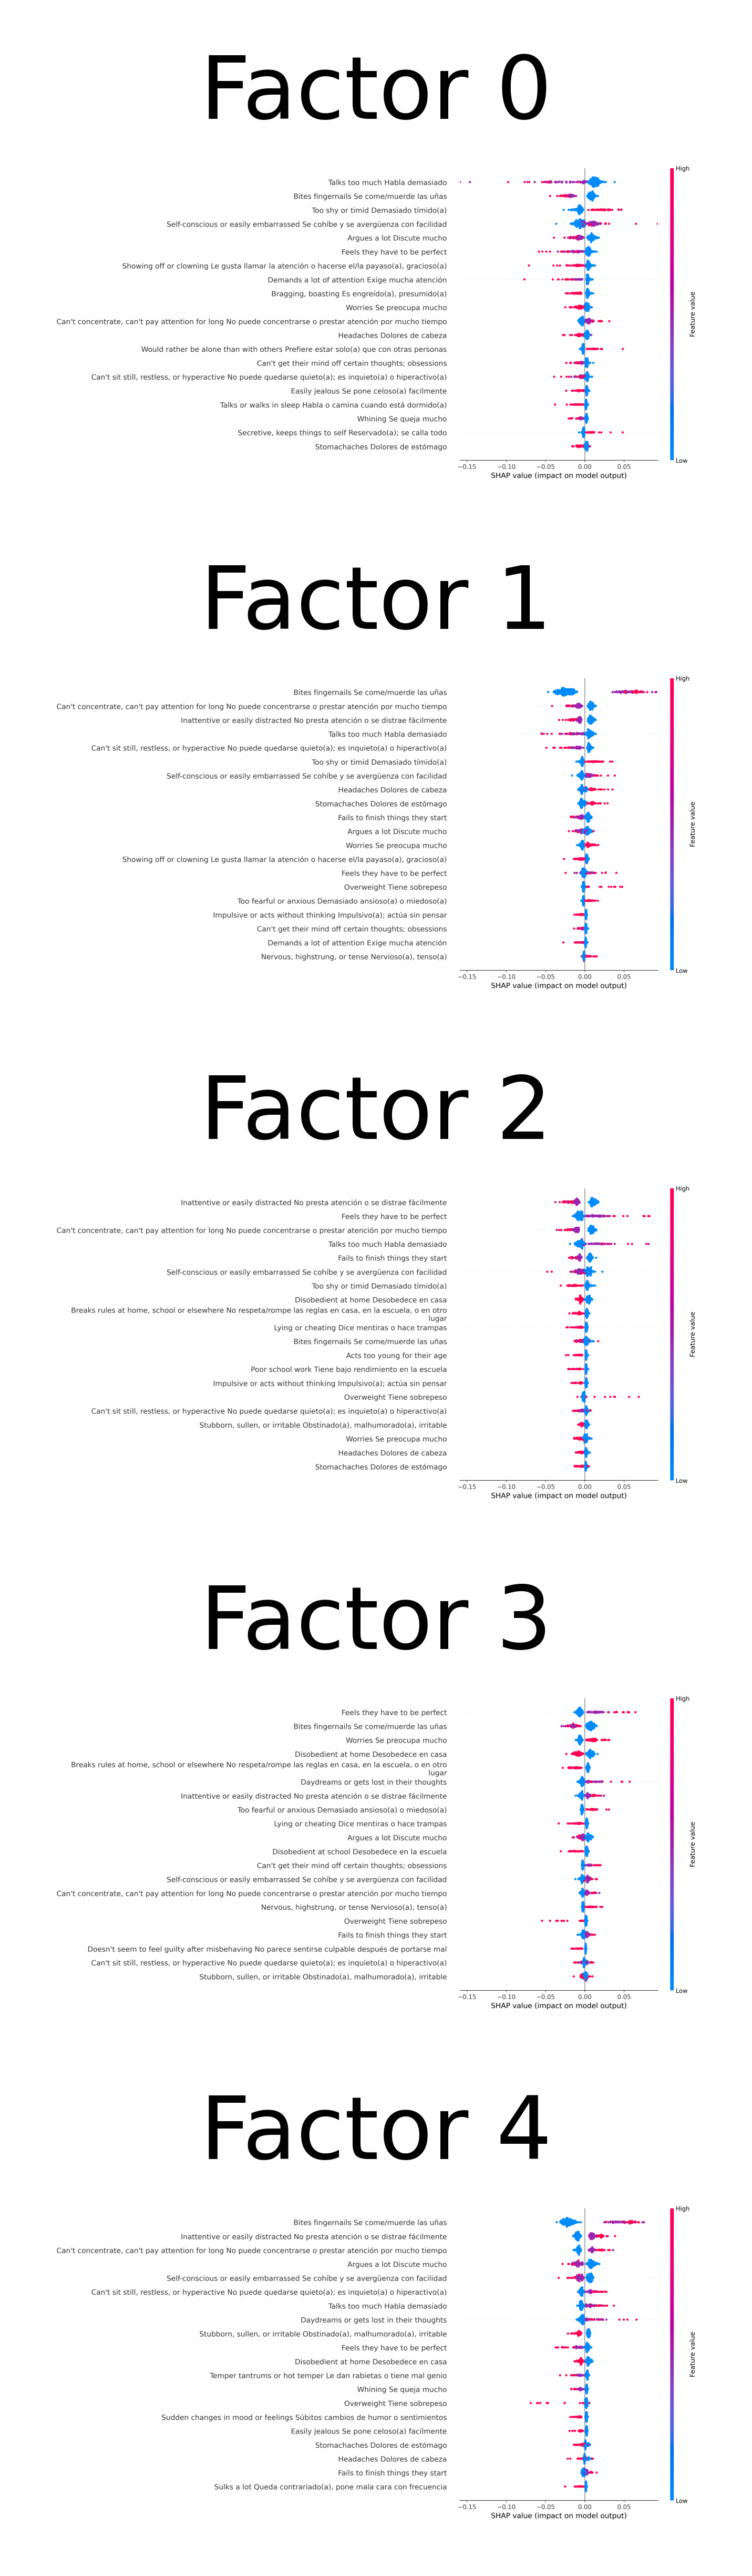

In [10]:
# We'll store each SHAP summary_plot as an in-memory PNG, then display them
images = []

for i in range(5):
    # 1) Create the SHAP summary plot on a brand-new figure
    shap.summary_plot(shap_values[:,:,i], X_test[:200], feature_names=items, show=False)
    plt.xlim(shap_values.min(), shap_values.max())
    
    # 2) Grab that just-created figure object
    tmp_fig = plt.gcf()
    
    # 3) Save it to a buffer in PNG format
    buf = io.BytesIO()
    tmp_fig.savefig(buf, format='png', bbox_inches='tight', dpi=300)
    buf.seek(0)
    
    # 4) Convert buffer -> PIL image and store
    images.append(Image.open(buf))
    
    # 5) Close that figure to avoid overlapping the next iteration
    plt.close(tmp_fig)

# Now create a single "master" figure of 1 row × 4 columns
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20,5), dpi=1000)

for idx, ax in enumerate(axes):
    # 6) Display each PIL image in its own subplot
    ax.imshow(images[idx])
    ax.set_axis_off()
    ax.set_title(f"Factor {idx}")

plt.tight_layout()
plt.show()


## NMF- Autoencoder

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import NMF

# 假设 X_train 已经定义为 NumPy 数组，X_test 同理。
# ----------------------------------------------------------------
# 1. 数据准备
X_train_np = np.array(X_train)
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. 定义模型超参数
input_dim = X_train_np.shape[1]
z_dim = 5               # 潜在因子维度
# 对于 Method1, 使用 无隐藏层 AE 以直接利用 NMF 初始化
ae_hidden_dims = []     # 取消所有隐藏层

# 3. NMF 分解
nmf_model = NMF(n_components=z_dim, init='random', max_iter=500)
W_nmf = nmf_model.fit_transform(X_train_np)    # (n_samples, z_dim)
H_nmf = nmf_model.components_                  # (z_dim, input_dim)
print(f"NMF 字典 H_nmf 形状: {H_nmf.shape}")
# 3. 还原重建结果
reconstructed = np.dot(W_nmf, H_nmf)

# 4. 计算潜变量 (W) 的每个因子的方差
latent_variances = np.var(W_nmf, axis=0)  # W 是 (n_samples, n_components)

# 5. 计算总方差
total_variance = np.var(X_train, axis=0).sum()

# 6. 每个潜变量解释方差的比例
explained_variance_ratios = latent_variances / total_variance

# 7. 样本级别重建误差（MSE）
reconstruction_errors = np.mean((X_train - reconstructed) ** 2, axis=1)

# 8. 重建后的总方差贡献
reconstruction_variance = np.var(reconstructed, axis=0).sum()
explained_variance_ratio_total = reconstruction_variance / total_variance

# 9. 打印
print("每个潜变量解释的方差比例：", explained_variance_ratios)
print("总重建解释方差比例：", explained_variance_ratio_total)
print("平均样本重建MSE：", reconstruction_errors.mean())


# 4. 构建无隐藏层的 AE (Encoder + Decoder)
class SimpleEncoder(nn.Module):
    def __init__(self, input_dim, z_dim):
        super(SimpleEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, 2*z_dim)
        self.z_dim = z_dim
    def forward(self, x):
        stats = self.fc(x)
        mu      = stats[:, :self.z_dim]
        logvar  = stats[:, self.z_dim:]
        return mu, logvar

class SimpleDecoder(nn.Module):
    def __init__(self, z_dim, output_dim, init_W=None):
        super(SimpleDecoder, self).__init__()
        self.fc = nn.Linear(z_dim, output_dim)
        if init_W is not None:
            # init_W shape must be (z_dim, output_dim)
            self.fc.weight.data.copy_(init_W)
            self.fc.bias.data.zero_()
    def forward(self, z):
        return self.fc(z)

class SimpleVAE(nn.Module):
    def __init__(self, enc, dec):
        super(SimpleVAE, self).__init__()
        self.encoder = enc
        self.decoder = dec
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

# 5. 实例化简单 AE 并用 NMF 字典初始化 Decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_ae  = SimpleEncoder(input_dim=input_dim, z_dim=z_dim)
decoder_ae  = SimpleDecoder(z_dim=z_dim, output_dim=input_dim,
                             init_W=torch.tensor(H_nmf.T, dtype=torch.float32))
ae_model = SimpleVAE(encoder_ae, decoder_ae).to(device)

# 6. AE 预训练（只用重建 MSE）
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=5e-4)
num_ae_epochs = 200
ae_model.train()
for epoch in range(1, num_ae_epochs+1):
    running_loss = 0.0
    for batch in train_loader:
        x = batch[0].to(device)
        recon, mu, logvar, z = ae_model(x)
        loss = F.mse_loss(recon, x, reduction='mean')
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print(f"[AE Pretrain] Epoch {epoch}/{num_ae_epochs}, Recon MSE: {running_loss/len(train_loader):.4f}")

# 7. 将预训练的 Decoder 权重 迁移回原始深度模型
# factor_vae.decoder.net[-1] 应对应解码器最后一层的 Linear
# 示例：
# factor_vae.decoder.net[-1].weight.data.copy_(ae_model.decoder.fc.weight.t())
# factor_vae.decoder.net[-1].bias.data.copy_(ae_model.decoder.fc.bias)

# 8. 添加 evaluate_on_data 方法

def evaluate_on_data(model, device, X):
    """
    在数据 X（numpy array 或 list）上评估：
    - 重建结果 reconstructed
    - 潜在因子 latent_factors
    - 每个潜在因子的解释方差比 explained_variance_ratios
    - 总体解释方差比 explained_variance_ratio_total
    - 每个样本的重建误差 reconstruction_errors

    返回：
      (latent_factors, reconstruction_errors,
       explained_variance_ratios,
       explained_variance_ratio_total,
       reconstructed)
    """
    model.eval()
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    with torch.no_grad():
        reconstructed, mu, logvar, z = model(X_tensor)
        latent_factors = z.cpu().numpy()

        latent_variances = np.var(latent_factors, axis=0)
        total_variance = np.var(X, axis=0).sum()
        explained_variance_ratios = latent_variances / total_variance

        reconstruction_errors = (
            (X_tensor - reconstructed).pow(2)
            .mean(dim=1)
            .cpu()
            .numpy()
        )

        reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
        explained_variance_ratio_total = reconstruction_variance / total_variance

    return (
        latent_factors,
        reconstruction_errors,
        explained_variance_ratios,
        explained_variance_ratio_total,
        reconstructed.cpu().numpy()
    )

# ======================================================================
# 后续可用 evaluate_on_data(ae_model, device, X_test) 查看预训练 AE 表现。
# 同理，对深度 FactorVAE 可使用相同函数进行评估。
# ======================================================================


NMF 字典 H_nmf 形状: (5, 114)
每个潜变量解释的方差比例： [0.04315717 0.02405365 0.0077928  0.00573274 0.00181195]
总重建解释方差比例： 0.3232178537214908
平均样本重建MSE： 0.02691365558442256
[AE Pretrain] Epoch 10/200, Recon MSE: 0.0345
[AE Pretrain] Epoch 20/200, Recon MSE: 0.0281
[AE Pretrain] Epoch 30/200, Recon MSE: 0.0271
[AE Pretrain] Epoch 40/200, Recon MSE: 0.0268
[AE Pretrain] Epoch 50/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 60/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 70/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 80/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 90/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 100/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 110/200, Recon MSE: 0.0266
[AE Pretrain] Epoch 120/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 130/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 140/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 150/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 160/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 170/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 180/200, Recon MSE: 0.0265
[AE P

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_3824\630952161.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


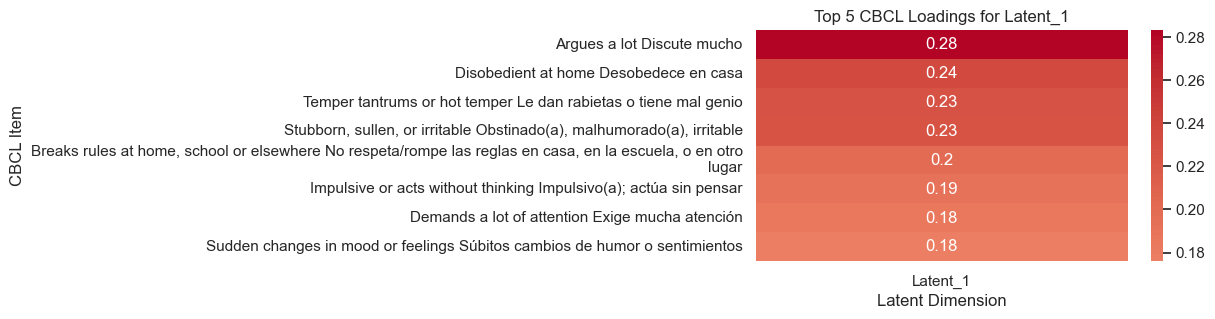

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_3824\630952161.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


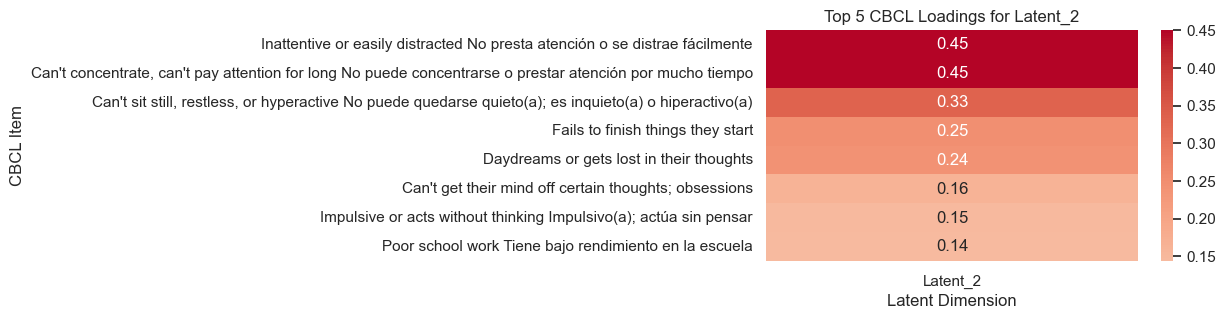

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_3824\630952161.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


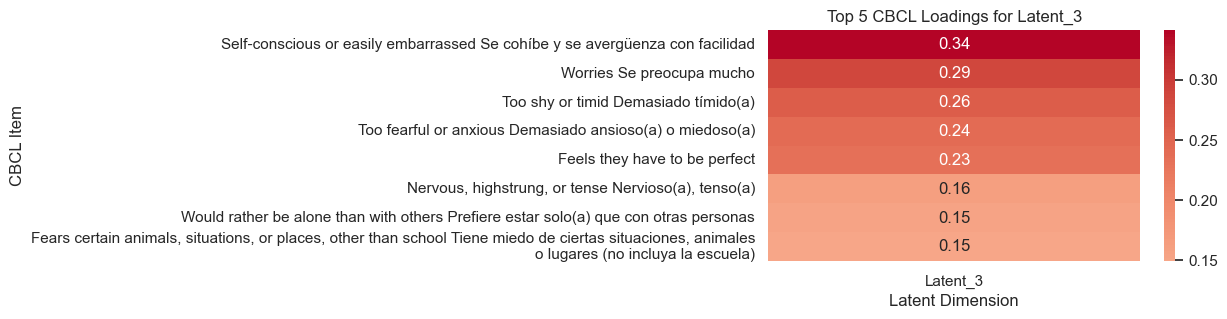

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_3824\630952161.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


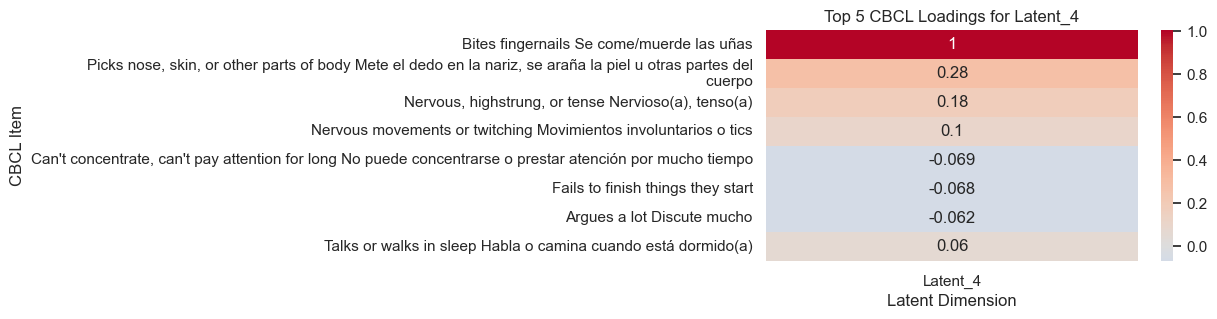

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_3824\630952161.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


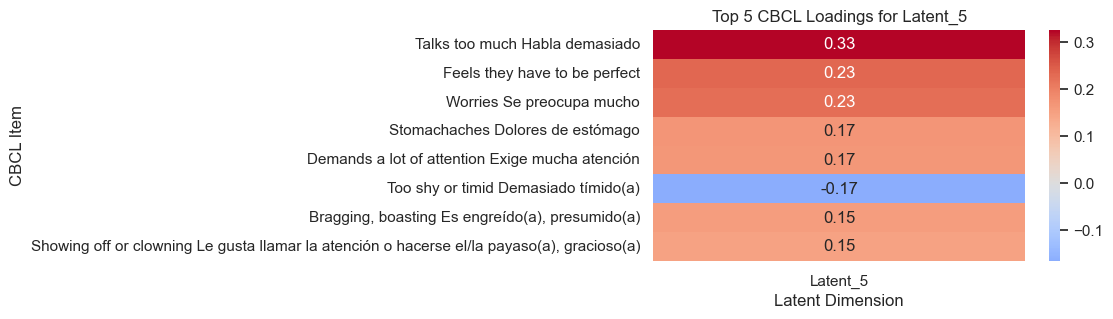

In [47]:
(
latent_factors,
reconstruction_errors,
explained_variance_ratios,
explained_variance_ratio_total,
reconstructed
        ) = evaluate_on_data(ae_model, 'cuda', X_train)  # 评估重建效果
explained_variance_ratio_total # 0.348534457451562
# reconstruction_errors.mean()

latent_factors = (
    latent_factors.values
    if isinstance(latent_factors, pd.DataFrame)
    else latent_factors
)
# original_features = X if isinstance(X, np.ndarray) else X.values
original_features = (
    X_train if isinstance(X_train, np.ndarray) else X_train.values
)

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]
scaler = StandardScaler()
latent_factors_scaled = scaler.fit_transform(latent_factors)
loadings = []

# regression for each original feature
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)


loadings_df = pd.DataFrame(
    loadings, columns=[f"Latent_{j+1}" for j in range(n_latent_factors)]
)
# loadings_df.index = [f"Feature_{i+1}" for i in range(n_original_features)]
loadings_df.index = items


# 设置风格
sns.set(style='whitegrid')

# 遍历每一列（latent）
for col in loadings_df.columns:
    # 获取当前列绝对值最大的前5个特征（CBCL item）
    top5 = loadings_df[col].abs().sort_values(ascending=False).head(8).index
    top5_data = loadings_df.loc[top5, [col]]

    # 绘图
    plt.figure(figsize=(6, 3))  # 每张图小一些方便展示
    sns.heatmap(top5_data, annot=True, cmap='coolwarm', center=0, cbar=True)
    plt.title(f"Top 5 CBCL Loadings for {col}")
    plt.xlabel("Latent Dimension")
    plt.ylabel("CBCL Item")
    plt.tight_layout()
    plt.show()